In [41]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from libs.print_cm import print_cm

         

from sklearn.model_selection import learning_curve, validation_curve

In [208]:
#Using Dataset for Data Scientist Job Change binary classification: 
# https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv
df = pd.read_csv("data/job_change_data_scientist.csv")
df_enc_0 = df.apply(LabelEncoder().fit_transform)
df_enc = df_enc_0.drop(columns=["enrollee_id","target"])
minMaxNorm = MinMaxScaler()
df_norm = minMaxNorm.fit_transform(df_enc)

X = df_norm
y = df_enc_0["target"].values



X = df_enc.values
y = df_enc_0["target"].values.astype('int32')
print(f"Xtype:{type(X)} ytype:{type(y)}")

Xtype:<class 'numpy.ndarray'> ytype:<class 'numpy.ndarray'>


In [190]:
from scipy.stats import randint

knn =  KNeighborsClassifier()

# (hidden_layer_sizes=(50,), max_iter=500, solver='sgd', learning_rate='invscaling', random_state=0)
# parameters = {'momentum':np.arange(0.1, 0.9, 0.1),'alpha':np.linspace(0.0001, 0.014, 10),
#              'learning_rate_init':np.linspace(0.00001, 0.0001,5),
#               }

parameters  = {'n_neighbors': np.linspace(1,15,15).astype('int32'), 'weights':['uniform','distance'], 'metric':[ 'chebyshev','euclidean', 'manhattan',
                              'minkowski']}

# scorer = make_scorer(recall_score)
# scorer = make_scorer(recall_score,average='weighted')
# scorer = make_scorer(f1_score, average='weighted' )
scorer = make_scorer(f1_score)
# scorer = make_scorer(fbeta_score, average='weighted', beta=2)
# scorer= make_scorer(precision_score)
strat_cv = StratifiedKFold(5, shuffle=True,  random_state=0)

knn_rand = RandomizedSearchCV(
    knn,
    parameters,
    n_iter=100,
    scoring=scorer,
    cv=strat_cv,
    n_jobs=-1,
    verbose=1,
    random_state=0
)



In [191]:
knn_rand.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'metric': ['chebyshev', 'euclidean',
                                                   'manhattan', 'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32),
                                        'weights': ['uniform', 'distance']},
                   random_state=0, scoring=make_scorer(f1_score), verbose=1)

In [192]:
# pd.DataFrame(knn_rand.cv_results_)

less_5 = pd.DataFrame(knn_rand.cv_results_)['rank_test_score'] <= 5

filtered_series = pd.DataFrame(knn_rand.cv_results_)[less_5].filter(['params','rank_test_score'])
sorted_series =  (filtered_series.sort_values(by=['rank_test_score']))
out_rows = [r for r in sorted_series.values]
# type(pd.DataFrame(mlp_rand.cv_results_)[less_5]['params'])
for r in out_rows:
    print( r[1],r[0])

pd.DataFrame(knn_rand.cv_results_)[less_5]

1 {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}
2 {'weights': 'distance', 'n_neighbors': 10, 'metric': 'manhattan'}
3 {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan'}
4 {'weights': 'uniform', 'n_neighbors': 13, 'metric': 'manhattan'}
5 {'weights': 'distance', 'n_neighbors': 13, 'metric': 'manhattan'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_metric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.022543,0.001079,0.309429,0.008209,uniform,9,manhattan,"{'weights': 'uniform', 'n_neighbors': 9, 'metr...",0.453268,0.488038,0.471883,0.472508,0.461916,0.469523,0.011656,3
41,0.020876,0.000622,0.286389,0.006266,uniform,13,manhattan,"{'weights': 'uniform', 'n_neighbors': 13, 'met...",0.453875,0.482633,0.462112,0.477738,0.470883,0.469448,0.010402,4
81,0.023388,0.001416,0.166934,0.020306,distance,13,manhattan,"{'weights': 'distance', 'n_neighbors': 13, 'me...",0.448529,0.486094,0.468999,0.471653,0.470223,0.469100,0.011998,5
88,0.021400,0.002332,0.173474,0.013857,distance,10,manhattan,"{'weights': 'distance', 'n_neighbors': 10, 'me...",0.456162,0.493199,0.466504,0.468034,0.466789,0.470138,0.012296,2
94,0.023307,0.000952,0.166362,0.007799,distance,9,manhattan,"{'weights': 'distance', 'n_neighbors': 9, 'met...",0.452899,0.496179,0.471446,0.467030,0.463609,0.470232,0.014348,1


In [209]:
knn_plain = KNeighborsClassifier(weights='distance', metric='manhattan')


cv_target = cross_validate(knn_rand.best_estimator_, X, y, cv=3, scoring=scorer)
cv_target

{'fit_time': array([0.01452398, 0.01033902, 0.00988913]),
 'score_time': array([0.1068449 , 0.09773803, 0.09582067]),
 'test_score': array([0.4765343 , 0.44655235, 0.47671033])}

In [210]:
scorer

make_scorer(f1_score)

In [211]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=0)
knn_plain.fit(X_train,y_train)
pass

In [212]:
def stats_pac( label, estimator, X_data, y_data ):
    predicted = estimator.predict(X_data)
    print ('****** %s ******' % label)
    cm = confusion_matrix(y_data, predicted)
    print ('Confusion matrix')
    print_cm(cm, labels=['0','1'])
    
    print ('Recall - label 0: %0.4f'% recall_score(y_data, predicted, pos_label=0))
    print ('Recall - label 1: %0.4f'% recall_score(y_data, predicted))

    print ('Precsion - label 0: %0.4f'% precision_score(y_data, predicted, pos_label=0))
    print ('Precsion - label 1: %0.4f'% precision_score(y_data, predicted))
    
    sample_wt = [ 3 if i == 1 else 1 for i in predicted]
    print ('F1 Score macro: %0.4f'% f1_score(y_data, predicted, average='macro', sample_weight=sample_wt ))
    print ('F1 Score - label 0 : %0.4f'% f1_score(y_data, predicted, pos_label=0 ))
    print ('F1 Score - label 1 : %0.4f'% f1_score(y_data, predicted, pos_label=1 ))
    print ('F1 Score - weighted avg : %0.4f'% f1_score(y_data, predicted, average='weighted' ))
    print ('F1 Beta - b=2 weighted avg : %0.4f'% fbeta_score(y_data,predicted, average='weighted', beta=2))
    
    print (classification_report(y_data, predicted, labels=[1,0]))


stats_pac('Knn plain - Train', knn_plain, X_train, y_train)
stats_pac('Knn plain - Validation', knn_plain, X_test, y_test)

stats_pac('Knn best estimator - Train', knn_rand.best_estimator_, X_train, y_train)
stats_pac('Knn plain - Validation', knn_rand.best_estimator_, X_test, y_test)

****** Knn plain - Train ******
Confusion matrix
              0     1 
        0 11504     0 
        1    14  3808 
Recall - label 0: 1.0000
Recall - label 1: 0.9963
Precsion - label 0: 0.9988
Precsion - label 1: 1.0000
F1 Score macro: 0.9994
F1 Score - label 0 : 0.9994
F1 Score - label 1 : 0.9982
F1 Score - weighted avg : 0.9991
F1 Beta - b=2 weighted avg : 0.9991
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3822
           0       1.00      1.00      1.00     11504

    accuracy                           1.00     15326
   macro avg       1.00      1.00      1.00     15326
weighted avg       1.00      1.00      1.00     15326

****** Knn plain - Validation ******
Confusion matrix
              0     1 
        0  2512   365 
        1   554   401 
Recall - label 0: 0.8731
Recall - label 1: 0.4199
Precsion - label 0: 0.8193
Precsion - label 1: 0.5235
F1 Score macro: 0.6731
F1 Score - label 0 : 0.8454
F1 Score - label 1 : 0.46

## Hyperparam K

In [213]:
## Plot iterations
knn_target =  KNeighborsClassifier(15,weights='distance', metric='manhattan')
# knn_target = KNeighborsClassifier()
print(knn_target.get_params())
strat_cv = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)

range_list = np.linspace(1, 50, 50).astype('int32')
range_list

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int32)

In [214]:
strat_cv

StratifiedKFold(n_splits=2, random_state=0, shuffle=True)

In [215]:
mlp_train_scores, mlp_test_scores = validation_curve(
    knn_target, X, y, param_name="n_neighbors", param_range=range_list,
    scoring=scorer, cv=strat_cv, n_jobs=-1)

In [216]:

train_scores_mean = np.mean(mlp_train_scores, axis=1)
test_scores_mean = np.mean(mlp_test_scores, axis=1)
print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_1 = pd.DataFrame({'x':range_list,'train':train_scores_mean,'test':test_scores_mean} )
df_1

(50,) (50,) (50,)


,x,train,test
0,1,0.999162,0.433032
1,2,0.999162,0.416105
2,3,0.999162,0.453120
3,4,0.999162,0.452351
4,5,0.999162,0.450883
5,6,0.999162,0.455427
6,7,0.999162,0.455058
7,8,0.999162,0.454261
8,9,0.999162,0.459383
9,10,0.999162,0.462661


In [217]:
scorer


make_scorer(f1_score)

Text(0.5, 1.0, 'KNN K Curve')

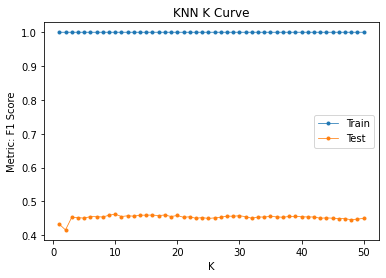

In [218]:
axs = plt.gca()
axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75, marker='.')
axs.plot(df_1['x'], df_1['test'], label='Test', linewidth=0.75, marker='.')
axs.legend(); axs.set_ylabel("Metric: F1 Score"); axs.set_xlabel("K")
axs.set_title('KNN K Curve')

## Try a new Hp

In [202]:
knn_target.get_params()


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 15,
 'p': 2,
 'weights': 'distance'}

In [203]:
# knn_target =  KNeighborsClassifier(algorithm='kd_tree')
knn_target =  KNeighborsClassifier(15, weights='distance')
# ??DistanceMetric

range_list = [ 'chebyshev','euclidean', 'manhattan',
                              'minkowski']

# range_list = np.linspace(5,50,20).astype('int32')
range_list

['chebyshev', 'euclidean', 'manhattan', 'minkowski']

In [112]:
scorer

make_scorer(f1_score)

In [204]:
mlp_train_scores, mlp_test_scores = validation_curve(
    knn_target, X, y, param_name="metric", param_range=range_list,
    scoring=scorer, cv=strat_cv, n_jobs=-1)

In [205]:
train_scores_mean = np.mean(mlp_train_scores, axis=1)
test_scores_mean = np.mean(mlp_test_scores, axis=1)
# print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_1 = pd.DataFrame({'x':range_list,'train':train_scores_mean,'test':test_scores_mean} )
df_1

,x,train,test
0,chebyshev,0.999162,0.426513
1,euclidean,0.999162,0.441741
2,manhattan,0.999162,0.459671
3,minkowski,0.999162,0.441741
